<a href="https://colab.research.google.com/github/JeongJeong-code/P7_scoring/blob/main/P7_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies et df

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import missingno as mi
from IPython.core.interactiveshell import InteractiveShell
from google.colab import drive
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
InteractiveShell.ast_node_interactivity = "all"
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path =r'/content/drive/MyDrive/P7_scoring/'
df = pd.read_csv(path + 'df_processed_V2.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'index', 'SK_ID_CURR', 'TARGET', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=759)

In [5]:
column_list = list(df.select_dtypes(exclude=object).columns)

In [6]:
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

In [7]:
#train_df = train_df.sample(10000)
train_df.drop(columns =['index','SK_ID_CURR','Unnamed: 0'],inplace = True)
test_df.drop(columns =['index','SK_ID_CURR','Unnamed: 0'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
train_df.columns

Index(['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_VAR',
       'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_MAX', 'CC_SK_DPD_DEF_MEAN',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_COUNT'],
      dtype='object', length=756)

# Gestion des Nan


In [9]:

nan_columns = pd.Series(train_df.columns[np.where(np.isnan(train_df).sum()>0)])
inf_columns = pd.Series(train_df.columns[np.where(np.isinf(train_df).sum()>0)])
serie_inf_nb = pd.Series(np.empty(len(inf_columns)))
serie_inf_ratio = pd.Series(np.empty(len(inf_columns)))
serie_nan_ratio = pd.Series(np.empty(len(nan_columns)))
serie_nan_nb = pd.Series(np.empty(len(nan_columns)))

for i in range(len(nan_columns)):
    serie_nan_nb[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()
    serie_nan_ratio[i] = np.isnan(train_df.loc[:,nan_columns[i]]).sum()/len(train_df)

nan_df = pd.concat([nan_columns,serie_nan_nb,serie_nan_ratio],axis=1)
nan_df.rename(columns = {0:'nan_columns',1:'nan_nb',2:'nan_ratio'},inplace= True )

for i in range(len(inf_columns)):
    serie_inf_nb[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()
    serie_inf_ratio[i] = np.isinf(train_df.loc[:,inf_columns[i]]).sum()/len(train_df)

inf_df = pd.concat([inf_columns,serie_inf_nb,serie_inf_ratio],axis=1)
inf_df.rename(columns = {0:'inf_columns',1:'inf_nb',2:'inf_ratio'},inplace = True )

In [10]:
#c= upper[to_drop].unstack()
#co = c.sort_values(ascending = False,kind="quicksort")
#co_90=co[co>0.90]
#co_90

In [11]:
train_df.replace([np.inf,-np.inf],np.nan,inplace = True)
test_df.replace([np.inf,-np.inf],np.nan,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [12]:
most_nan =nan_df[nan_df['nan_ratio'] >0.5]

In [13]:
most_nan

,nan_columns,nan_nb,nan_ratio
3,OWN_CAR_AGE,202927.0,0.659910
5,EXT_SOURCE_1,173376.0,0.563812
8,APARTMENTS_AVG,156060.0,0.507501
9,BASEMENTAREA_AVG,179942.0,0.585164
11,YEARS_BUILD_AVG,204486.0,0.664980
...,...,...,...
571,CC_SK_DPD_DEF_MAX,220602.0,0.717389
572,CC_SK_DPD_DEF_MEAN,220602.0,0.717389
573,CC_SK_DPD_DEF_SUM,220602.0,0.717389
574,CC_SK_DPD_DEF_VAR,221234.0,0.719444


In [14]:
for column in train_df.columns:
    train_df[column].fillna(train_df[column].mean(),inplace = True)
for column in test_df.columns:
    test_df[column].fillna(test_df[column].mean(),inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
train_df.drop(columns = most_nan['nan_columns'],inplace = True)
test_df.drop(columns = most_nan['nan_columns'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Corrélation entre colonnes 


In [16]:
# Create correlation matrix
corr_matrix = test_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
#df.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [17]:
for column in train_df.columns:
 train_df = train_df[np.abs(train_df[column]-train_df[column].mean()) <= (5*train_df[column].std())]

In [18]:
train_df_light = train_df.drop(columns=to_drop)
test_df_light = test_df.drop(columns=to_drop)
train_df_light = train_df.copy()
test_df_light = test_df.copy()
for column in test_df_light.columns:
    test_df_light.fillna(test_df_light[column].mean(),inplace = True)   
for column in train_df_light.columns:
    train_df_light[column].fillna(train_df_light[column].mean(),inplace = True)



In [19]:
np.shape(train_df)

(36830, 560)

In [20]:
X=train_df.drop(columns = 'TARGET')
X_light = train_df_light.drop(columns = 'TARGET')
y = train_df.TARGET

In [21]:
train_df.TARGET.describe()

count    36830.000000
mean         0.074776
std          0.263033
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

In [22]:
pd.DataFrame(X_light).describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,...,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,36830.000000,36830.000000,36830.000000,36830.000000,3.683000e+04,3.683000e+04,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.0,36830.000000,36830.000000,36830.0,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.0,36830.0,36830.0,36830.000000,36830.000000,36830.00000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,...,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,36830.000000,3.683000e+04,36830.0,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,36830.000000,3.683000e+04,36830.000000,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,3.683000e+04,36830.000000,36830.000000,36830.000000,36830.000000
mean,0.705675,0.275753,0.271979,0.308281,1.427650e+05,5.360542e+05,24620.161988,4.796377e+05,0.019652,-17640.938556,-2114.787717,-5507.329161,-3229.452512,1.0,0.577084,0.128917,1.0,0.251100,0.036546,2.008526,2.111132,2.095004,11.750339,0.0,0.0,0.0,0.060521,0.163725,0.12574,0.499005,0.535162,0.979478,0.222637,0.979014,0.219147,0.979489,0.222321,0.098929,1.338035,0.113349,...,0.459806,0.784926,0.045169,0.914129,0.000001,0.000159,2.409450e-07,0.076836,0.000022,0.000229,0.008623,3.287919e-09,0.0,31.708867,2.143078,7.791627,0.483777,21.593481,37.213672,12.253652,413.667771,2.622185,1.020781,40.400537,1499.143866,5827.601315,77.060778,8158.530996,6.080870e+07,94232.600014,14370.381581,5.761700e+05,4002.738854,95253.181898,14293.238711,5.678961e+05,-268.181268,-889.664590,-40115.260386,40.254894
std,0.455745,0.446899,0.444985,0.638016,6.880692e+04,3.538535e+05,12685.680651,3.215773e+05,0.012192,4729.153934,1273.851965,3745.933266,1472.842538,0.0,0.494029,0.335112,0.0,0.433652,0.187648,0.846966,0.468165,0.461402,3.130283,0.0,0.0,0.0,0.238453,0.370031,0.33156,0.192927,0.160199,0.005007,0.076408,0.005150,0.076056,0.005016,0.076642,0.052455,2.106326,0.340367,...,1.401616

# Scaling des données

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_light = StandardScaler()
X_ul = X_light.copy()
X_u =X.copy()
scaler.fit(X)
scaler_light.fit(X_light)
X = scaler.transform(X)
X_light = scaler_light.transform(X_light)

StandardScaler()

StandardScaler()

In [24]:
X_col = train_df.columns
X_col = X_col[1:]

X_light_col = train_df_light.columns
X_light_col = X_light_col[1:]

# SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,sampling_strategy='minority')
#del train_df
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_l, y_resampled_l = smote.fit_resample(X_light, y)

In [26]:
np.shape(X_resampled)

(68152, 559)

In [27]:
#del X
#del y

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,train_size=0.8)
X_train_l,X_test_l,y_train_l,y_test_l = train_test_split(X_resampled_l,y_resampled_l,train_size=0.8)

In [29]:
X_train = pd.DataFrame(X_train,columns = train_df.columns[1:])
X_test = pd.DataFrame(X_test,columns = train_df.columns[1:])
X_train_l = pd.DataFrame(X_train_l,columns = train_df_light.columns[1:])
x_test_l = pd.DataFrame(X_test_l,columns = train_df_light.columns[1:])

# Principal Component Analysis


In [30]:
y.value_counts()

0.0    34076
1.0     2754
Name: TARGET, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


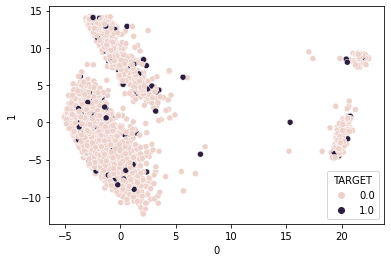

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_light)
X_pca = pca.transform(X_light)
pca_result = pd.concat([pd.DataFrame(X_pca),y],axis=1)
sns.scatterplot(pca_result[0],pca_result[1],hue=pca_result.TARGET)

In [32]:
#np.argsort(np.abs(pca.components_[0]))[::-1]

In [33]:
#np.argmax(X_light[479,:])

In [34]:
#pca.explained_variance_

# modèles de prédiction


In [35]:

lr = LogisticRegression()
gb = GaussianNB()
svc = LinearSVC()
dtc = DecisionTreeClassifier()

In [36]:
#cross_val_score(gb,X_train,y_train,cv=5).mean()


In [37]:
#cross_val_score(gb,X_train_l,y_train_l,cv=5).mean()

In [38]:
# résultats gb:
# drop nan à 50% de remplissage + input nan valeur median --> cv =0.536 acc.
# drop nan 50% + input nan valeur median + drop colonnes corrélées à 95% --> 0.517 acc.
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop --> 0.548 acc./0.5219
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop + scaling via robust scaler -->0.5315/0.539
#drop nan 50% + inpute nan mean value + sans drop colonnes corrélées/avec drop +imputation sur outliers + scaling via robust scaler -->

In [39]:
#gb_pred_l = gb.fit(X_train_l,y_train_l).predict(X_test_l)
#from sklearn.metrics import confusion_matrix
#display(pd.DataFrame(confusion_matrix(y_test_l,gb_pred_l)))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, gb_pred_l)
#display(metrics.auc(fpr, tpr))

In [40]:
#svc_pred_l = svc.fit(X_train_l,y_train_l).predict(X_test_l)
#
#pd.DataFrame(confusion_matrix(y_test_l,svc_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, svc_pred_l)
#display(metrics.auc(fpr, tpr))

In [41]:
#lr_pred_l = lr.fit(X_train,y_train).predict(X_test)
#from sklearn.metrics import confusion_matrix
#pd.DataFrame(confusion_matrix(y_test_l,lr_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, lr_pred_l)
#display(metrics.auc(fpr, tpr))

In [42]:
#dtc_pred_l = dtc.fit(X_train_l,y_train_l).predict(X_test_l)
#pd.DataFrame(confusion_matrix(y_test_l,dtc_pred_l))
#fpr, tpr, thresholds = metrics.roc_curve(y_test_l, dtc_pred_l)
#display(metrics.auc(fpr, tpr))

In [43]:
#suppresion des cols corrélés : essayer imputation mean/median avant corr
# standard scaler sur les df
# detection d'outlier? --> voir avec robust scaler
# quels axes d'amélio sur la lr

# Optimisation de regression logistique via Optuna



In [44]:
#!pip install optuna
import optuna

In [45]:
def objective(trial):    
    penalty = trial.suggest_categorical('Penalty',['none','l2'])
    C = trial.suggest_float('C',1,100,step =10 )
    solver = trial.suggest_categorical('solver',['lbfgs'])
    #l1_ratio = trial.suggest_float('l1_ratio',0,1,step =0.1)
    return cross_val_score(
        lr, X_train_l,y_train_l, cv=5).mean()

In [46]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

# Optimisation tree-based models


In [47]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
cross_val_score(clf,X_train_l,y_train_l)

array([0.89995415, 0.89664343, 0.902146  , 0.90223771, 0.89334189])

In [48]:
y_pred_l = clf.fit(X_train_l,y_train_l).predict(X_test_l)
pd.DataFrame(confusion_matrix(y_test_l,y_pred_l))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


,0,1
0,6111,726
1,493,6301


In [49]:
from sklearn import tree

In [50]:

def objective(trial):    
    criterion = trial.suggest_categorical('criterion',['gini'])
    max_depth = trial.suggest_float('max_depth',2,10,step =1)
    min_samples_split = trial.suggest_float('min_samples_split',1,41,step =10)
    min_samples_leaf = trial.suggest_float('min_samples_leaf',1,21,step =10)
    #l1_ratio = trial.suggest_float('l1_ratio',0,1,step =0.1)
    return cross_val_score(
        clf, X_train_l,y_train_l, cv=2,scoring='precision').mean()

In [51]:
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)

#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [94]:
best_tree = DecisionTreeClassifier(criterion ='gini',max_depth =7,min_samples_split =10,min_samples_leaf=11)

In [95]:
bt1 = best_tree.fit(X_train_l,y_train_l)


In [54]:
cross_val_score(bt1,X_train_l,y_train_l,scoring='precision',cv=2)

array([0.82472228, 0.84469609])

<Figure size 2160x2160 with 0 Axes>

[Text(0.4305889423076923, 0.9375, 'X[0] <= 0.646\ngini = 0.5\nsamples = 54521\nvalue = [27239, 27282]'),
 Text(0.1814903846153846, 0.8125, 'X[0] <= -1.548\ngini = 0.44\nsamples = 23648\nvalue = [7723, 15925]'),
 Text(0.171875, 0.6875, 'X[85] <= -0.807\ngini = 0.495\nsamples = 14030\nvalue = [7723, 6307]'),
 Text(0.10817307692307693, 0.5625, 'X[29] <= 0.273\ngini = 0.34\nsamples = 4752\nvalue = [3718, 1034]'),
 Text(0.052884615384615384, 0.4375, 'X[92] <= 0.799\ngini = 0.433\nsamples = 2613\nvalue = [1783, 830]'),
 Text(0.028846153846153848, 0.3125, 'X[92] <= -1.235\ngini = 0.499\nsamples = 925\nvalue = [487, 438]'),
 Text(0.019230769230769232, 0.1875, 'X[190] <= 1.193\ngini = 0.406\nsamples = 679\nvalue = [487, 192]'),
 Text(0.009615384615384616, 0.0625, 'gini = 0.46\nsamples = 450\nvalue = [289, 161]'),
 Text(0.028846153846153848, 0.0625, 'gini = 0.234\nsamples = 229\nvalue = [198, 31]'),
 Text(0.038461538461538464, 0.1875, 'gini = 0.0\nsamples = 246\nvalue = [0, 246]'),
 Text(0.07692

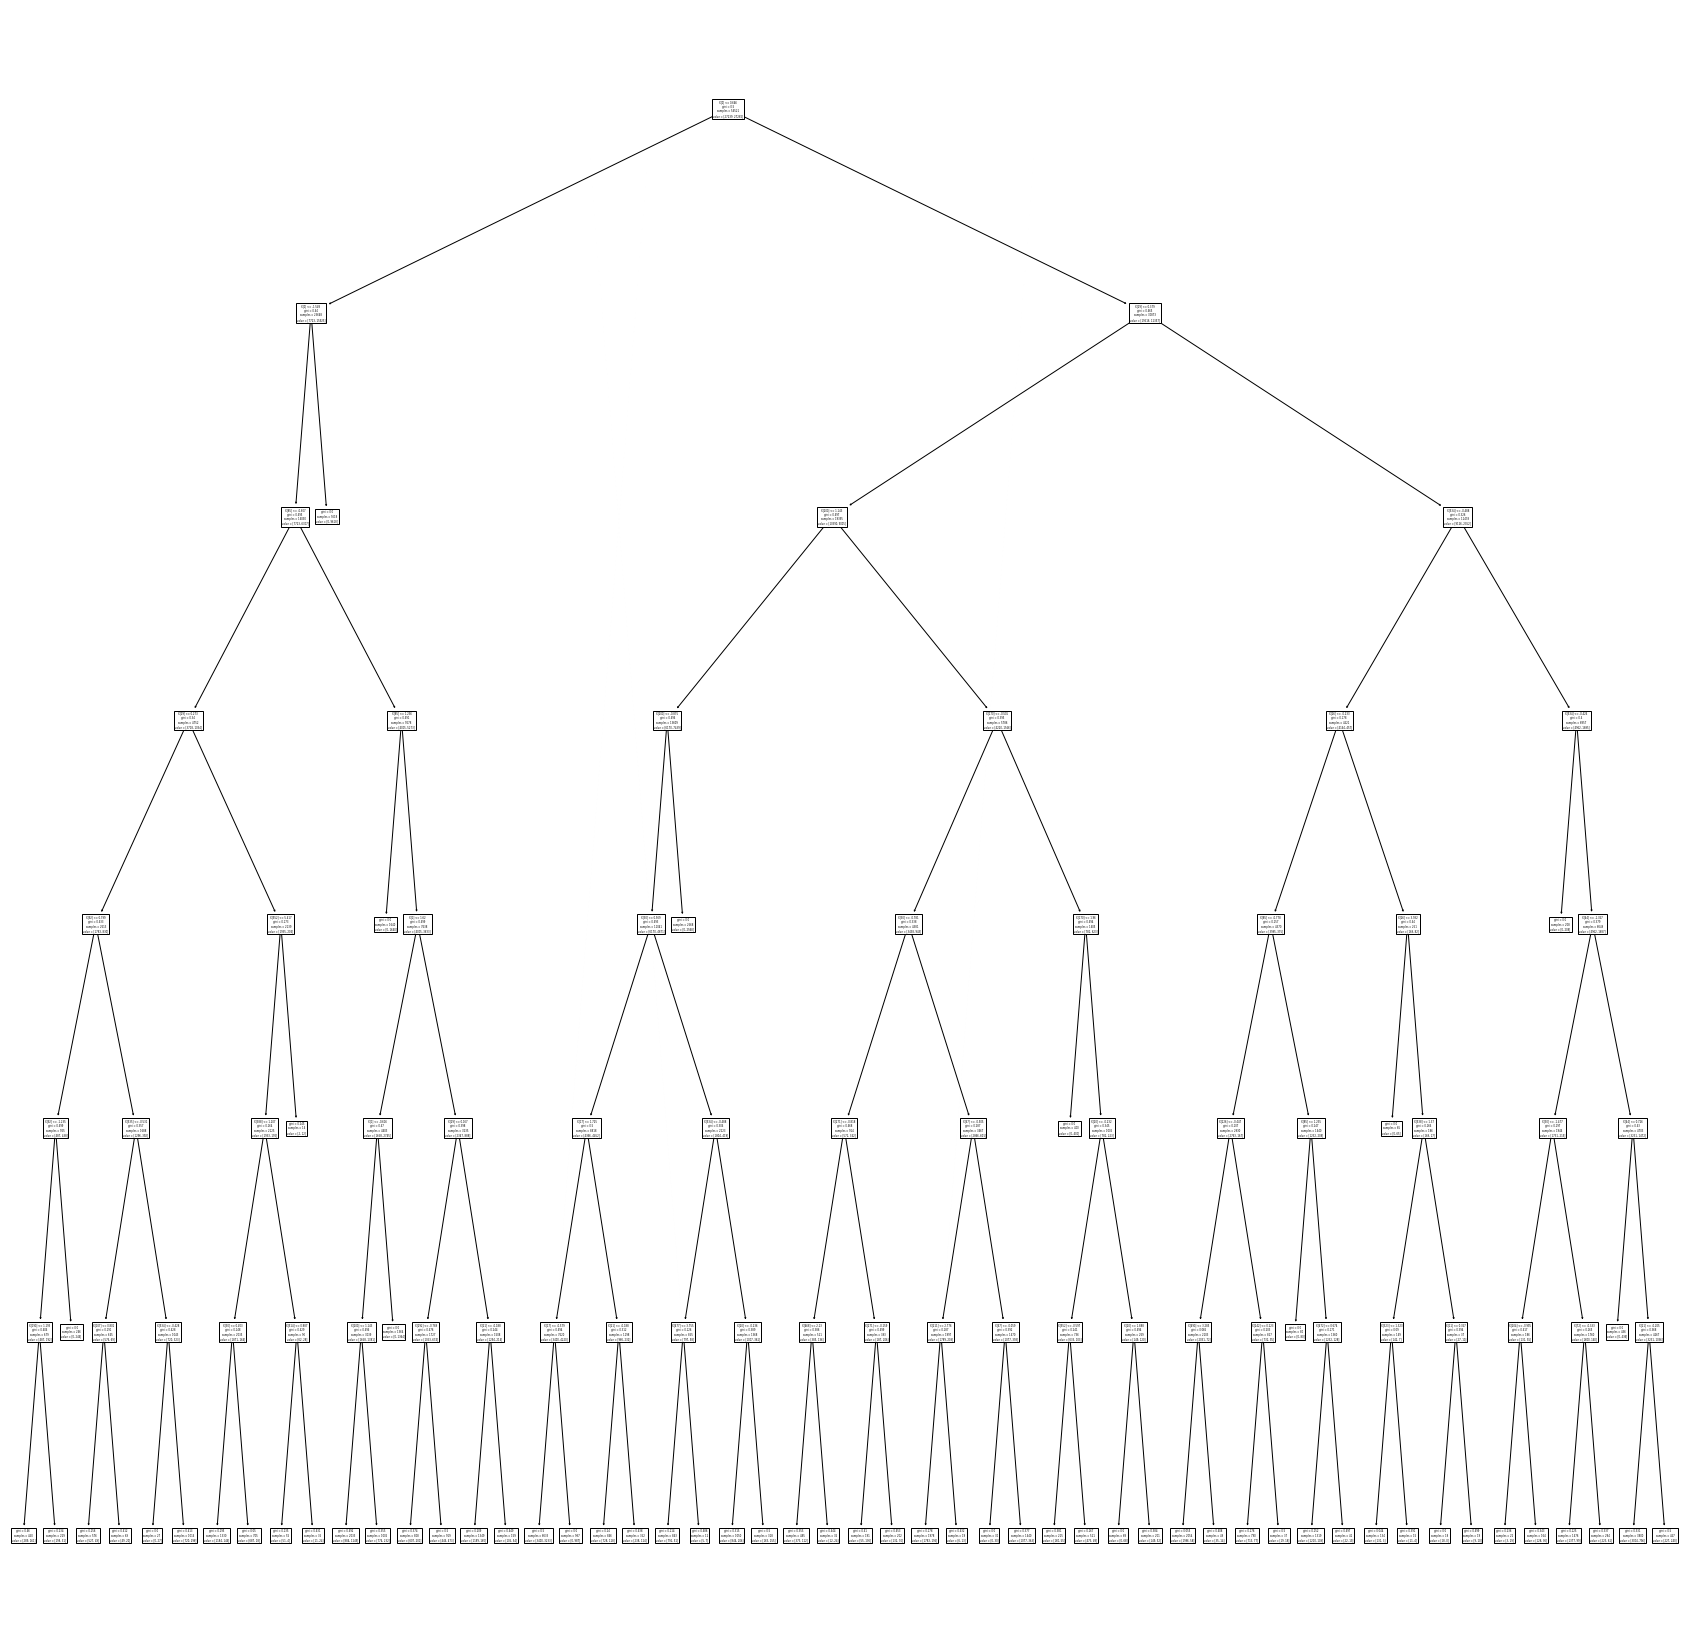

In [55]:
plt.figure(figsize=(30,30))
tree.plot_tree(bt1)

In [56]:
feat = best_tree.feature_importances_

In [102]:
def feat_importance(features,cols):
  feat_indexes =np.flatnonzero(features)
  feat_values = features[feat_indexes]
  feat_names = cols[feat_indexes]

  feat_indexes = pd.Series(feat_indexes,name ='feat_indexes')
  feat_values = pd.Series(feat_values,name ='feat_values')
  feat_names = pd.Series(feat_names,name = 'feat_names')

  features_df = pd.concat([feat_names,feat_indexes,feat_values],axis =1)
  features_df.sort_values(by=['feat_values'],ascending =False,inplace =True)
  plt.figure(figsize=(8,8))
  if len(features_df)>10:
    features_df_plot = features_df.iloc[0:20,:].copy()
  else:
    features_df_plot = features_df.copy()

  sns.barplot(data = features_df_plot,x = 'feat_values',y='feat_names')
  return(feat_names)

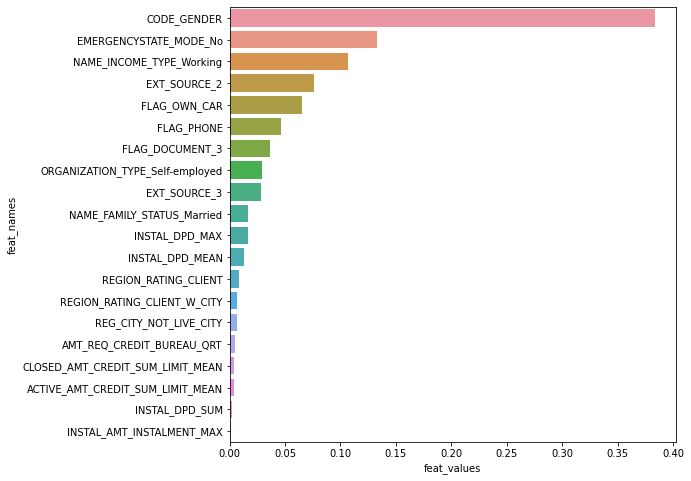

In [105]:
#cross_val_score(best_tree,X_train_l,y_train_l,cv=5,scoring ='precision')
#cross_val_score(best_tree,X_train_l,y_train_l,cv=5,scoring ='accuracy')
ft_names=feat_importance(bt1.feature_importances_,X_train_l.columns)

In [59]:
bt2 = best_tree.fit(X_train,y_train)


In [98]:
df_corr = pd.concat([train_df['CODE_GENDER'],train_df['NAME_INCOME_TYPE_Working']],axis =1)

In [110]:
df_corr2 = train_df[ft_name]

In [111]:
df_corr2.corr()

,CODE_GENDER,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_3,"WALLSMATERIAL_MODE_Stone, brick",INCOME_PER_PERSON,ANNUITY_INCOME_PERC,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_VAR,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,PREV_AMT_CREDIT_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_DAYS_DECISION_MIN,PREV_CNT_PAYMENT_SUM,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_NAME_TYPE_SUITE_Family_MEAN,"PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN",PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_CREDIT_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_CNT_PAYMENT_MEAN,POS_MONTHS_BALANCE_MEAN,POS_SK_DPD_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INSTAL_DPD_MEAN,INSTAL_DBD_MEAN,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM
CODE_GENDER,1.000000,-0.024271,-0.211339,-0.075248,-0.094480,0.017128,0.038659,0.030610,0.019638,-0.038940,0.081581,-0.011887,0.012337,-0.027879,-0.123142,-0.080464,-0.086501,-0.052113,-0.026252,-0.111015,-0.020552,0.004342,-0.067483,-0.032969,-0.022772,-0.041634,-0.057886,-0.048572,0.106976,-0.032511,0.024890,0.040087,0.002281,0.031061,-0.091651,-0.108173,-0.062384,-0.056825,0.015637,0.001925,-0.022480,-0.039336,-0.039935,0.000185,0.064681,0.096514,-0.011193,-0.025537,0.054150,-0.017202,-0.017189,-0.004492,0.024222,-0.012353,0.035643,0.017387,0.035883,0.019104,0.065976,-0.014424,-0.046584
REGION_POPULATION_RELATIVE,-0.024271,1.000000,-0.033112,-0.006772,-0.034634,0.164312,-0.002536,-0.053034,0.005717,0.096474,-0.029045,-0.011302,0.005991,-0.001016,0.036263,0.027388,0.034858,0.018270,0.011658,0.044407,0.004240,0.005164,0.033451,0.010069,0.025815,0.019464,0.121949,-0.049644,-0.005095,-0.000601,0.005118,0.001664,-0.003389,-0.011152,0.001572,-0.019161,-0.029620,0.009340,0.044241,0.034377,0.026575,0.018497,0.043084,0.042472,0.037978,-0.013852,-0.056309,0.045462,-0.004729,0.006318,0.005061,0.031482,0.020047,-0.007726,0.008578,0.022811,0.008841,0.023623,0.034670,-0.060348,-0.058242
DAYS_BIRTH,-0.211339,-0.033112,1.000000,0.306261,0.315394,-0.068511,-0.183502,0.239371,-0.018362,-0.065437,-0.044312,0.130186,-0.096087,0.095345,0.093814,0.075246,0.077772,0.064544,0.086954,0.072974,0.013020,-0.063083,0.111796,0.035062,0.031529,0.038094,0.184486,0.120069,-0.180842,0.032086,-0.013464,-0.053112,0.042700,-0.041003,0.083861,0.230171,0.035905,0.210764,-0.072357,-0.067240,0.031004,0.034860,0.036922,-0.072295,-0.173332,-0.211988,0.066288,-0.030549,-0.106588,-0.001820,-0.048253,-0.033771,-0.034070,0.030035,-0.062855,-0.090694,-0.063270,-0.093642,-0.133530,0.089818,0.109745
DAYS_EMPLOYED,-0.075248,-0.006772,0.306261,1.000000,0.121740,-0.072122,-0.103403,0.039243,-0.005453,-0.023734,-0.017293,0.092134,-0.055884,0.074084,-0.004452,0.003808,0.023361,0.035652,0.027742,-0.007863,-0.007032,-0.034304,0.086085,0.017828,-0.023803,0.023637,0.049301,0.121878,-0.081657,0.004084,-0.001933,-0.019726,0.025346,-0.033686,0.011222,0.097789,0.019305,0.077279,-0.086057,-0.011829,-0.024700,0.023197,-0.027354,-0.016628,-0.096458,-0.069425,0.087782,-0.003640,-0.043574,-0.001801,0.012583,0.005143,-0.045608,0.003997,-0.043645,-0.056933,-0.044048,-0.056189,-0.097

In [89]:
len(train_df[train_df['CODE_GENDER']==0])

10840

In [90]:
len(train_df[train_df['CODE_GENDER']==1])

25990

In [79]:
df_corr.corr()

,CODE_GENDER,TARGET
CODE_GENDER,1.000000,-0.075523
TARGET,-0.075523,1.000000


array([0.82802198, 0.85273632, 0.91523263, 0.82849315, 0.87446726])

array([0.82796882, 0.82446809, 0.85794204, 0.82932869, 0.85409024])

()

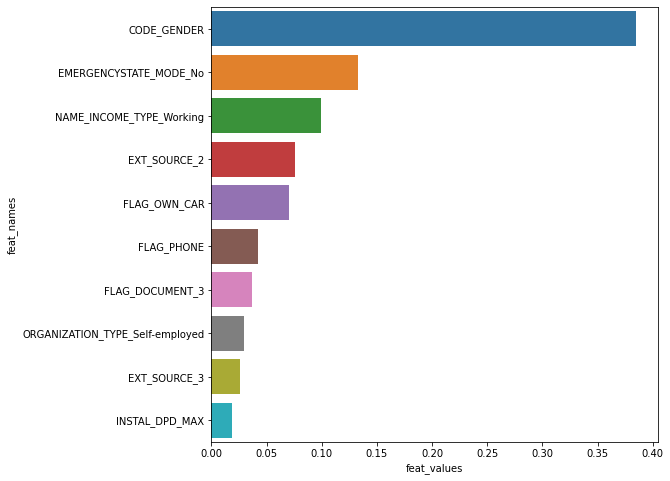

In [60]:
cross_val_score(best_tree,X_train,y_train,cv=5,scoring ='precision')
cross_val_score(best_tree,X_train,y_train,cv=5,scoring ='accuracy')
feat_importance(bt2.feature_importances_,X_train.columns)

In [70]:
X_df = pd.DataFrame(X_train,columns = X_col)
X_df_test = pd.DataFrame(X_test,columns = X_col)

In [62]:
X_df.drop(columns = 'CODE_GENDER',inplace = True)

In [63]:
bt3 = best_tree.fit(X_df,y_train)

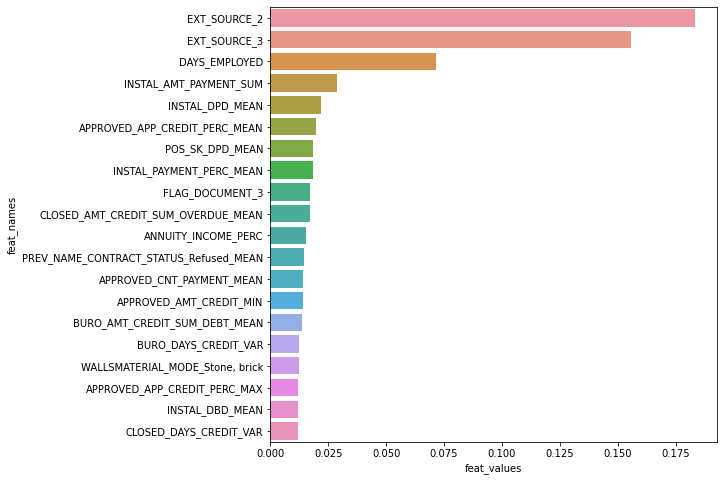

In [104]:
#cross_val_score(best_tree,X_df,y_train,cv=5,scoring ='precision')
#cross_val_score(best_tree,X_df,y_train,cv=5,scoring ='accuracy')
ft_name = feat_importance(bt3.feature_importances_,X_df.columns)

In [71]:
y_pred_bt3 = bt3.predict(X_test)
y_prob_bt3 = bt3.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [75]:
prob_df = pd.DataFrame(y_prob_bt3)

In [112]:
prob_df.head()

,0,1
0,0.795964,0.204036
1,0.895197,0.104803
2,0.961115,0.038885
3,0.968575,0.031425
4,0.770408,0.229592


In [65]:
cross_val_score(best_tree,X_df,y_train,cv=2)

array([0.81765159, 0.82820983])

array([0.19298246, 0.20408163, 0.26785714, 0.23893805, 0.34782609])

()

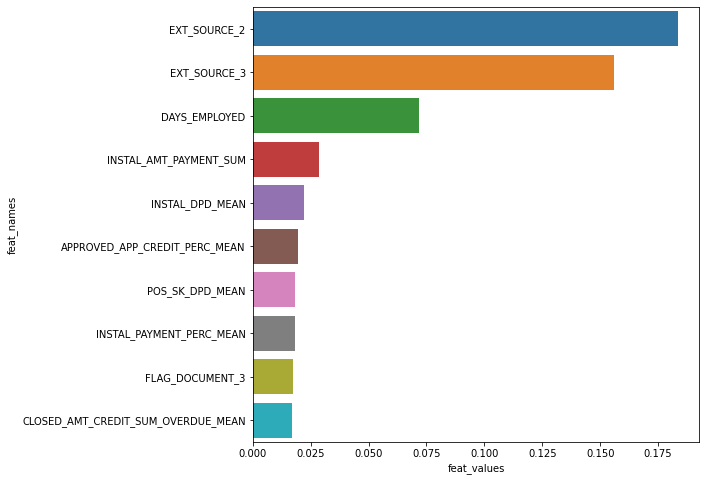

In [66]:
#X_tr,X_te,y_tr,yte = train_test_split(X_li+ght,y,train_size=0.8)
#bt4 = best_tree.fit(X_tr,y_tr)
#cross_val_score(best_tree,X_tr,y_tr,cv=5,scoring ='precision')
#feat_importance(bt4.feature_importances_,X_light_col)

In [67]:
#X_tr,X_te,y_tr,yte = train_test_split(X,y,train_size=0.8)
#bt5 = best_tree.fit(X_tr,y_tr)
#cross_val_score(best_tree,X_tr,y_tr,cv=5,scoring='precision')
#feat_importance(bt5.feature_importances_,X_light_col)

In [68]:
#cross_val_score(best_tree,X_ul,y,cv=5,scoring ='precision')
#cross_val_score(best_tree,X_ul,y,cv=5,scoring ='accuracy')
#bt6 = best_tree.fit(X_ul,y)
#feat_importance(bt6.feature_importances_,X_train_l.columns)

In [69]:
#cross_val_score(best_tree,X_u,y,cv=5,scoring ='precision')
#cross_val_score(best_tree,X_u,y,cv=5,scoring ='accuracy')
#bt7 = best_tree.fit(X_u,y)
#feat_importance(bt7.feature_importances_,X_train_l.columns)